In [1]:
# load packages
import pandas as pd
from typing import Optional

import numpy as np

from sklearn.metrics import accuracy_score, classification_report

import os

import torch

import torch.nn as nn

from datetime import date
import logging as log
from models.dataset import Dataset as Dataset


from models.utils import add_horizons, normalize,normalize_apply,normalize_train,ad_normalize,normalize_by_prev_day,print_cfm,compute_pnl


In [37]:
# parameters
tickers="gdx"
#tickers="slv,"
#tickers=("slv",)
iteration_no=14
model_shortname="all"
#0-> 10, 1->50,2->100
horizon_mapping = {
    0: 25,
    1: 50,
    2: 75
}
horizon_to_predict=1
look_back_window=100
batch_size=64
alpha=0.02

In [38]:
model_checkpoint_loc=f"/results2/iteration{iteration_no}"
log_loc=f"./results2/iteration{iteration_no}"
os.makedirs(f".{model_checkpoint_loc}", exist_ok=True)
tickers = tuple(x.strip() for x in tickers.split(","))
print(f"Running model with params Ticker: {tickers} Horizon Idx:{horizon_to_predict} window:{look_back_window} training batch size:{batch_size} alpha {alpha} iteration {iteration_no}")

Running model with params Ticker: ('gdx',) Horizon Idx:1 window:100 training batch size:64 alpha 0.02 iteration 14


In [39]:
# Configure basic logging to a file
log.basicConfig(
    filename=f"{log_loc}/pnl.log",  # Name of the log file
    level=log.INFO,             # Minimum logging level to capture (e.g., INFO, DEBUG, WARNING, ERROR, CRITICAL)
    format='%(asctime)s - %(levelname)s - %(message)s',  # Format of the log messages
    datefmt='%Y-%m-%d %H:%M:%S'      # Format for the timestamp
)

In [40]:
data_path="/home/nnagarajan/github/DNNLOB-FA800/data/etf/jan2025/cleaned2/"
#data_path="data/"
prefix="_cleaned_jan2025"

In [41]:
for ticker in tickers:
    log.info(f"Processing {ticker}")
    print(f"Processing {ticker}")    
    dataset_test: Optional[Dataset] = None
    df = pd.read_csv(f"{data_path}{ticker}{prefix}.csv",engine="pyarrow",sep = ',')
    print(df.describe())
    df["Date-Time"] = pd.to_datetime(df["Date-Time"])
    df["Date-Time"] = df["Date-Time"].dt.tz_convert("America/New_York")
    df=add_horizons(df,tuple(horizon_mapping.values()),alpha)
    class_summary = df.groupby(f"Target_{horizon_mapping[horizon_to_predict]}").size().reset_index(name="Count")
    # Calculate relative percentage
    class_summary["Percent"] = (class_summary["Count"] / class_summary["Count"].sum()) * 100
    class_summary["Percent"] = class_summary["Percent"].round(2)
    print(class_summary)
    #df=ad_normalize(df,100)
    normalize(df)
    print(df.head(5))
    #normalize_by_prev_day(df)
    df["Date"] = pd.to_datetime(df["Date-Time"]).dt.date
    df.groupby(["Date"]).size()    
    df_test = df[(df["Date"] >= date(2025, 1, 30)) & (df["Date"] <= date(2025, 1, 31))]
    #df_train, scaler = normalize_train(df_train)
    #df_val = normalize_apply(df_val,scaler)
    #df_test = normalize_apply(df_test,scaler)
    target_cols = [f"Target_{i}" for i in list(horizon_mapping.values())]
    price_cols = [f"L{i}-BidPrice" for i in range(1, 11)] + [f"L{i}-AskPrice" for i in range(1, 11)]
    size_cols  = [f"L{i}-BidSize"  for i in range(1, 11)] + [f"L{i}-AskSize"  for i in range(1, 11)]        
    df_test =  df_test[price_cols + size_cols +target_cols]
    if None in (dataset_test,):        
        dataset_test = Dataset(data=df_test.to_numpy(), k=horizon_to_predict, num_classes=3, T=look_back_window)
    else:        
        dataset_test1 = Dataset(data=df_test.to_numpy(), k=horizon_to_predict, num_classes=3, T=look_back_window)        

        dataset_test.merge(dataset_test1)

Processing gdx
          rel.spread     abs.spread      mid_price    L1-BidPrice  \
count  376096.000000  376096.000000  376096.000000  376096.000000   
mean        0.000437       0.016064      36.874918      36.866886   
std         0.000227       0.008233       1.357510       1.357677   
min         0.000252       0.010000      34.570000      34.560000   
25%         0.000272       0.010000      35.640000      35.630000   
50%         0.000507       0.020000      36.910000      36.900000   
75%         0.000549       0.020000      37.750000      37.740000   
max         0.009379       0.330000      39.740000      39.730000   

          L1-BidSize    L1-AskPrice     L1-AskSize    L2-BidPrice  \
count  376096.000000  376096.000000  376096.000000  376096.000000   
mean      855.307794      36.882951     885.980571      36.856582   
std      1036.515501       1.357355    1052.958081       1.357733   
min         1.000000      34.580000       1.000000      34.550000   
25%       200.0000

In [42]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [43]:
test_loader = torch.utils.data.DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=False)

print(dataset_test.x.shape, dataset_test.y.shape)

torch.Size([49810, 1, 100, 40]) torch.Size([49810])


accuracy_score: 0.8164625577193335
              precision    recall  f1-score   support

           0     0.8376    0.9266    0.8798     36057
           1     0.7326    0.5328    0.6169      7033
           2     0.7305    0.5225    0.6092      6720

    accuracy                         0.8165     49810
   macro avg     0.7669    0.6606    0.7020     49810
weighted avg     0.8083    0.8165    0.8062     49810



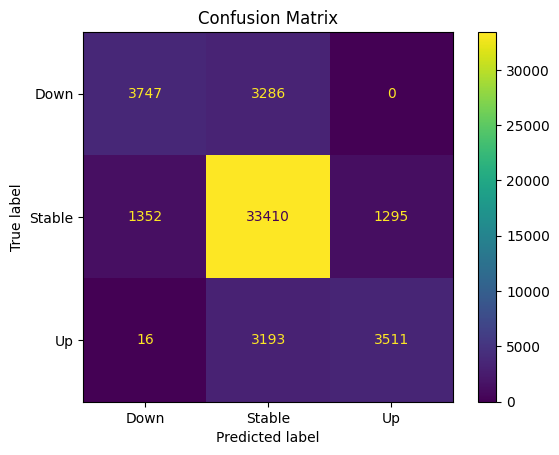

In [44]:
from models.deeplob import deeplob as deeplob
model = deeplob(device=device,y_len = dataset_test.num_classes)
model.to(device)
model_savepoint=f"{model_checkpoint_loc}/best_val_model_{model_shortname}_deeplob.pt"
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
from models.gd import GradientDescent as GradientDescent
all_targets, all_predictions = GradientDescent(device).evaulate_model(model_savepoint, model, test_loader)
print('accuracy_score:', accuracy_score(all_targets, all_predictions))
print(classification_report(all_targets, all_predictions, digits=4))
print_cfm(all_targets,all_predictions)

In [45]:
df_test = df[(df["Date"] >= date(2025, 1, 30)) & (df["Date"] <= date(2025, 1, 31))]
print(len(df_test))
df_test2 = df_test.iloc[99:].reset_index(drop=True)
print(len(df_test2))
df_test

49909
49810


,#RIC,Date-Time,rel.spread,abs.spread,mid_price,L1-BidPrice,L1-BidSize,L1-AskPrice,L1-AskSize,L2-BidPrice,...,L10-AskPrice,L10-AskSize,isEOD,Raw_Target_25,Target_25,Raw_Target_50,Target_50,Raw_Target_75,Target_75,Date
326187,GDX,2025-01-30 09:40:00.022856550-05:00,0.000514,0.02,38.920,0.841393,0.012114,0.839768,0.006535,0.841393,...,0.786618,0.009686,False,0.0614,2,0.0232,2,0.017133,0,2025-01-30
326188,GDX,2025-01-30 09:40:00.022856550-05:00,0.000257,0.01,38.925,0.843327,0.048699,0.839768,0.028466,0.843327,...,0.786618,0.009686,False,0.1046,2,0.0456,2,0.031533,2,2025-01-30
326189,GDX,2025-01-30 09:40:00.413125311-05:00,0.000514,0.02,38.920,0.841393,0.003984,0.839768,0.028466,0.841393,...,0.786618,0.009686,False,0.1482,2,0.0678,2,0.045933,2,2025-01-30
326190,GDX,2025-01-30 09:40:00.593321437-05:00,0.000257,0.01,38.925,0.843327,0.008049,0.839768,0.028466,0.843327,...,0.786618,0.009686,False,0.1914,2,0.0904,2,0.060333,2,2025-01-30
326191,GDX,2025-01-30 09:40:01.033392560-05:00,0.000514,0.02,38.920,0.841393,0.003984,0.839768,0.028466,0.841393,...,0.786618,0.009686,False,0.2350,2,0.1128,2,0.074733,2,2025-01-30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376091,GDX,2025-01-31 15:49:32.868304325-05:00,0.000256,0.01,39.025,0.862669,0.162520,0.859073,0.004342,0.862669,...,0.804702,0.039336,False,0.0154,0,0.0358,2,0.061133,2,2025-01-31
376092,GDX,2025-01-31 15:49:35.083573926-05:00,0.000512,0.02,39.030,0.862669,0.195041,0.861004,0.008728,0.862669,...,0.808318,0.019569,False,0.0146,0,0.0356,2,0.060733,2,2025-01-31
376093,GDX,2025-01-31 15:49:35.087604450-05:00,0.000256,0.01,39.025,0.862669,0.219431,0.859073,0.004342,0.862669,...,0.804702,0.039336,False,0.0130,0,0.0356,2,0.060200,2,2025-01-31
376094,GDX,2025-01-31 15:49:48.092446991-05:00,0.000512,0.02,39.030,0.862669,0.154390,0.861004,0.008728,0.862669,...,0.808318,0.019569,False,0.0122,0,0.0356,2,0.059933,2,2025-01-31


In [46]:
print(horizon_mapping[horizon_to_predict])
print(np.array_equal(df_test2[f"Target_{horizon_mapping[horizon_to_predict]}"].to_numpy(), all_targets))
df_test2=df_test2[["mid_price",f"Target_{horizon_mapping[horizon_to_predict]}","isEOD"]]
df_test2["prediction"]=all_predictions

50
True


In [55]:
compute_pnl(df_test2,slippage=0,k_delay=5)

(np.float64(3.499999999999659),
     entry_idx  exit_idx  entry_price  exit_price   pnl
 0         368      1015       38.940      39.010   7.0
 1        1137      1228       39.045      38.995  -5.0
 2        1755      1817       39.030      39.000  -3.0
 3        1972      2684       38.990      39.020   3.0
 4        2870      3641       39.030      39.180  15.0
 ..        ...       ...          ...         ...   ...
 59      43567     44302       39.110      39.095  -1.5
 60      46037     46261       39.105      39.095  -1.0
 61      47050     47524       39.030      39.010  -2.0
 62      48744     48880       38.880      38.860  -2.0
 63      49486     49809       38.920      39.025  10.5
 
 [64 rows x 5 columns],
        mid_price  Target_50  isEOD  prediction  position  exec_buy  exec_sell
 0         38.915          0  False           0         0     False      False
 1         38.910          0  False           0         0     False      False
 2         38.920          0  Fal

In [104]:
df_test2

,mid_price,Target_50,isEOD,prediction
0,21.035,0,False,0
1,21.040,0,False,0
2,21.035,0,False,0
3,21.040,0,False,0
4,21.035,0,False,0
...,...,...,...,...
132616,20.560,0,False,0
132617,20.565,0,False,0
132618,20.570,0,False,0
132619,20.565,0,False,0
